In [79]:
import numpy as np 
import FlowCytometryTools
from FlowCytometryTools import FCMeasurement
from FlowCytometryTools import FCPlate
from FlowCytometryTools import ThresholdGate, PolyGate
import matplotlib.pyplot as plt
import scipy as sp
import scipy.special
import seaborn as sns
import pandas as pd
import datetime as dt

FSCHgateupper = ThresholdGate(6550.0, ['FSC-H'], region='below')
FSCHgatelower = ThresholdGate(5100.0, ['FSC-H'], region='above')
SSCHgatelower = ThresholdGate(4800.0, ['SSC-H'], region='above') 
SSCHgateupper = ThresholdGate(5600.0, ['SSC-H'], region='below')
scatter_gates = FSCHgateupper & FSCHgatelower & SSCHgatelower & SSCHgateupper


bfp_threshold = [[{"A1":7425,"A3":7425,"C1":7425,"C3":7425,"B1":7570,"B3":7570,"D1":7650,"D3":7750,"E1":7550,"E3":7495}],
                 [{"A1":7425,"A3":7425,"C1":7475,"C3":7475,"B1":7570,"B3":7570,"D1":7600,"D3":7600,"E1":7600,"E3":7600},
                  {"A1":7425,"A3":7425,"C1":7425,"C3":7450,"B1":7570,"B3":7570,"D1":7600,"D3":7700,"E1":7600,"E3":7500},
                  {"A1":7450,"A3":7425,"C1":7450,"C3":7450,"B1":7600,"B3":7600,"D1":7800,"D3":7800,"E1":7600,"E3":7500}]]
yfp_threshold = 6150

days = list(range(2))
plate_num = list(range(1,4))
plates = {}

for day in days:
    list_plates = []
    datadir = '/Users/kristenlok/Desktop/2.8.22_monoculture_flucts/D{}/'.format(str(day))
    if day == 1:
        for p in plate_num:
            datadir = '/Users/kristenlok/Desktop/2.8.22_monoculture_flucts/D1/p{}/'.format(str(p))
            plate = FCPlate.from_dir(ID='96-well', path=datadir, parser='name')
            plate_transformed = plate.transform('hlog', channels=['BFP-H','YFP-H'], b=100.0).transform('hlog', channels=['FSC-H','SSC-H'], b=10.0**2).gate(scatter_gates)
            list_plates.append(plate_transformed)
    else:
        plate = FCPlate.from_dir(ID='96-well', path=datadir, parser='name')
        plate_transformed = plate.transform('hlog', channels=['BFP-H','YFP-H'], b=100.0).transform('hlog', channels=['FSC-H','SSC-H'], b=10.0**2).gate(scatter_gates)
        list_plates.append(plate_transformed) 
    plates[day] = list_plates
    

/Users/kristenlok/opt/anaconda3/lib/python3.8/site-packages/FlowCytometryTools/core/transforms.py:180: RuntimeWarning: divide by zero encountered in log10
  lxmin = max([log10(abs(xmin)), 0])


In [80]:
def f1_expectation(theta,f1obs_data,f2obs_data,nmax=100):
    f1,lam = theta
    f2=1-f1
    f1obs=0
    f2obs=0
    for k in range(1,nmax):
        f1obs+=((f1*lam)**k)/scipy.special.factorial(k)/(np.exp(lam)-1)
        f2obs+=((f2*lam)**k)/scipy.special.factorial(k)/(np.exp(lam)-1)
    return f1obs-f1obs_data, f2obs-f2obs_data


def get_bfp_freq(data, day, plate_num, well):
    bfp_pos = data['BFP-H']>bfp_threshold[day][plate_num][well]
    yfp_pos = data['YFP-H']>yfp_threshold
    bfp_neg = data['BFP-H']<bfp_threshold[day][plate_num][well]
    yfp_neg = data['YFP-H']<yfp_threshold

    bfp = len(data[bfp_pos & yfp_neg])
    yfp = len(data[yfp_pos & bfp_neg])
    dp = len(data[bfp_pos & yfp_pos])
    Q = bfp + yfp + dp
    func = lambda theta: f1_expectation(theta,bfp/Q,yfp/Q)
    res = sp.optimize.root(func, [bfp/Q, 0.5])

    bfp_mean = np.float(data[bfp_pos & yfp_neg]['BFP-H'].mean())
    yfp_mean = np.float(data[yfp_pos & bfp_neg]['YFP-H'].mean())
    return res.x, Q, bfp_mean, yfp_mean

[[<FCOrderedCollection '96-well'>], [<FCOrderedCollection '96-well'>, <FCOrderedCollection '96-well'>, <FCOrderedCollection '96-well'>]]


/Users/kristenlok/opt/anaconda3/lib/python3.8/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


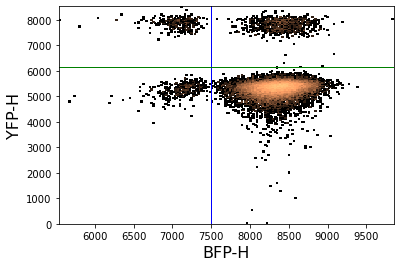

In [81]:
b_gate = ThresholdGate(7495, ['BFP-H'], region='above')
y_gate = ThresholdGate(6150, ['YFP-H'], region='above')


all_plates = list(plates.values())
print(all_plates)
for plate in all_plates:
    all_plates[0][0]['E3'].plot(['BFP-H', 'YFP-H'], gates=[b_gate, y_gate])


In [82]:
def plot_plates(day, plate_num, well, bfp_threshold, yfp_threshold):
    b_gate = ThresholdGate(bfp_threshold[day][plate_num][well], ['BFP-H'], region='above')
    all_plates = list(plates.values())
    for plate in all_plates:
        all_plates[day][plate_num][well].plot(['BFP-H', 'YFP-H'], gates=[b_gate, y_gate])
                

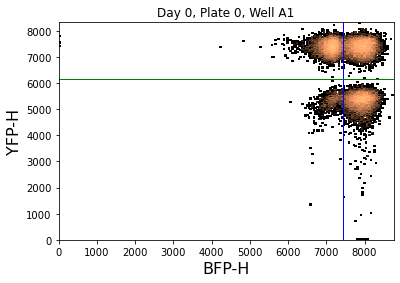

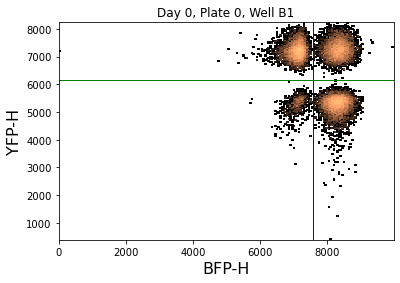

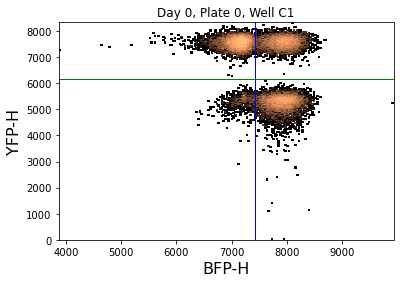

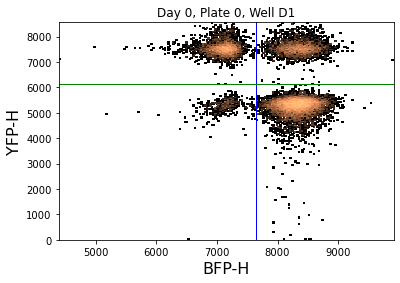

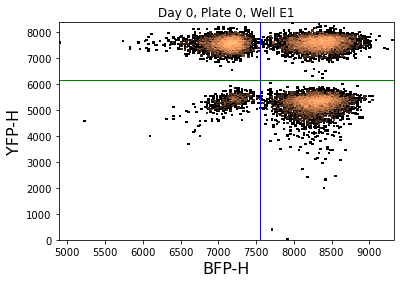

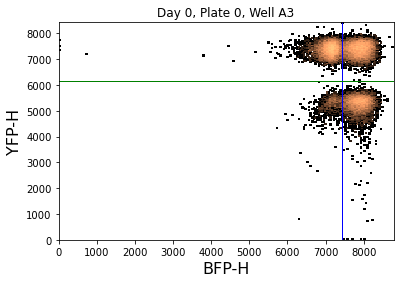

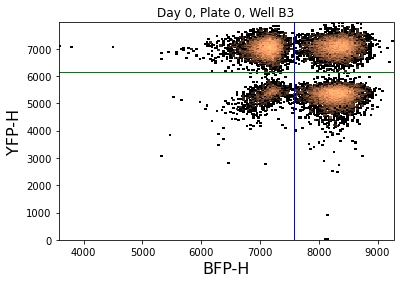

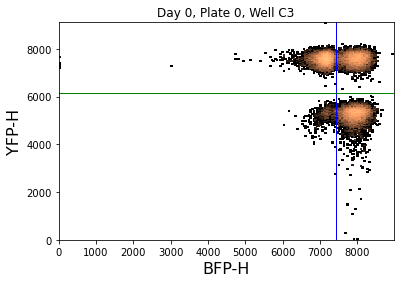

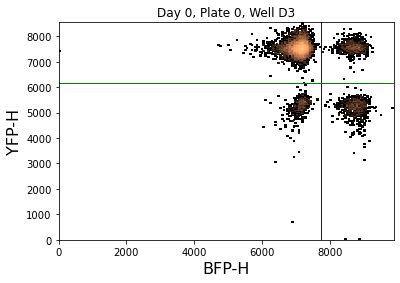

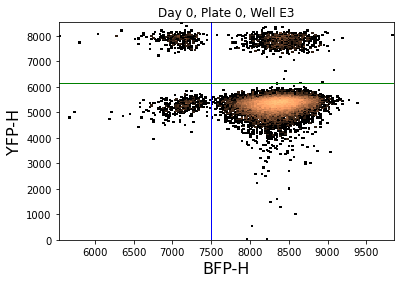

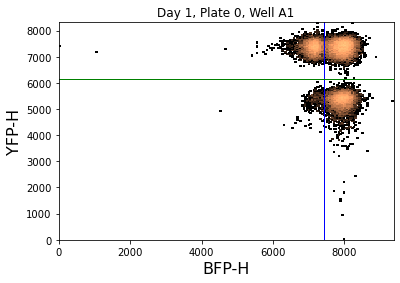

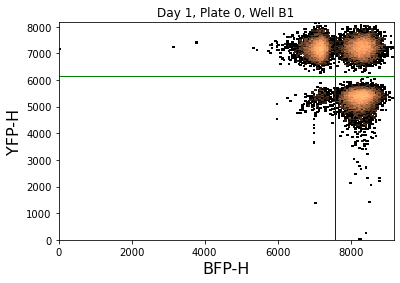

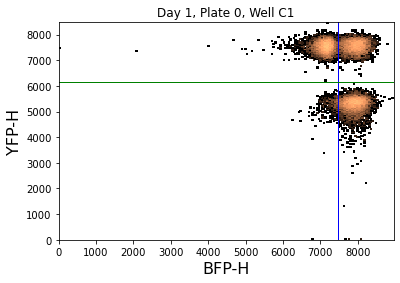

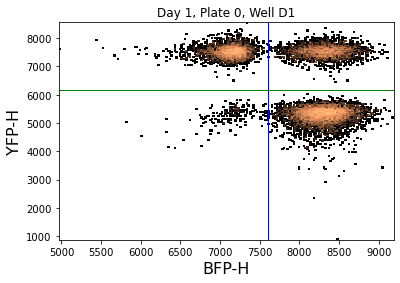

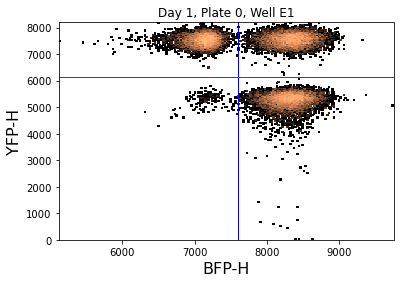

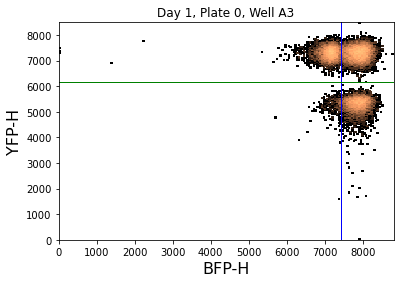

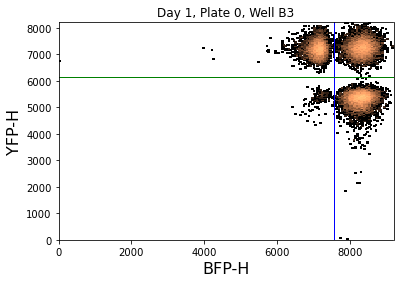

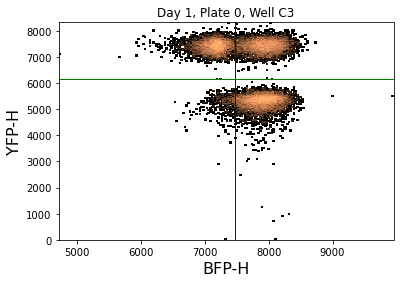

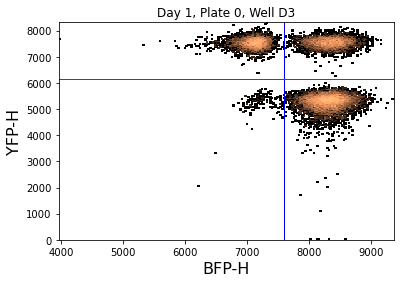

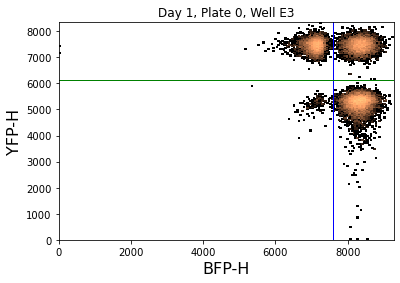

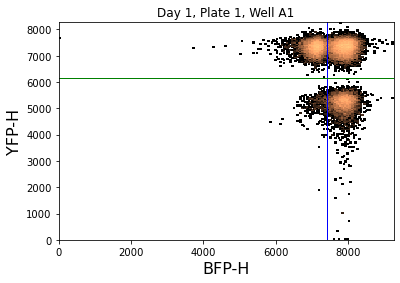

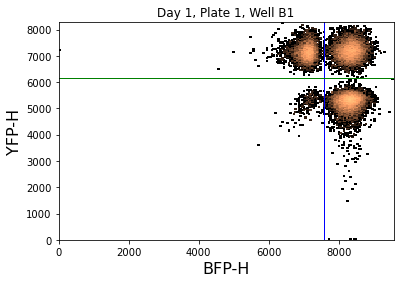

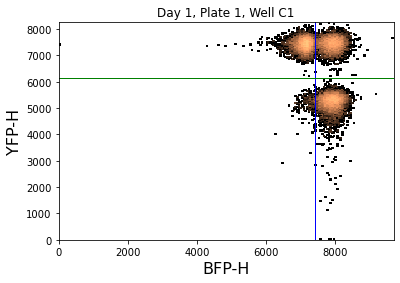

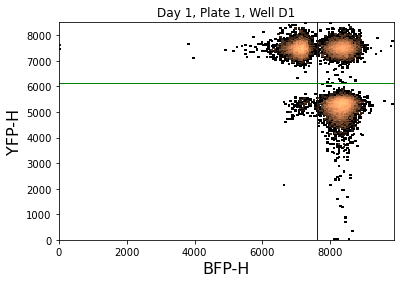

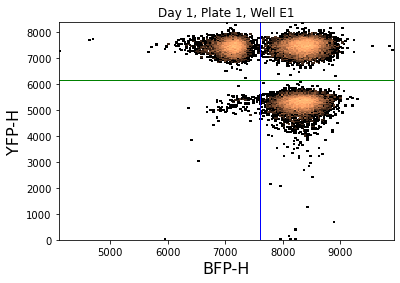

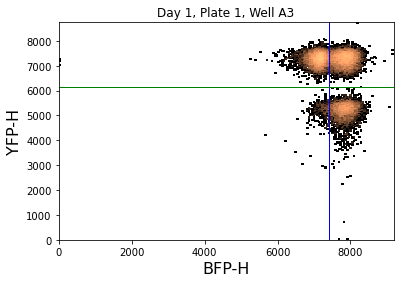

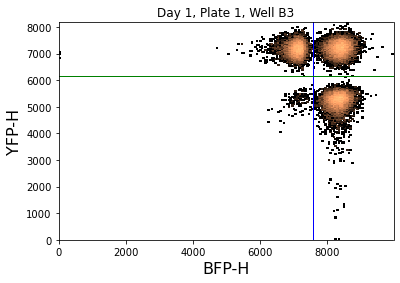

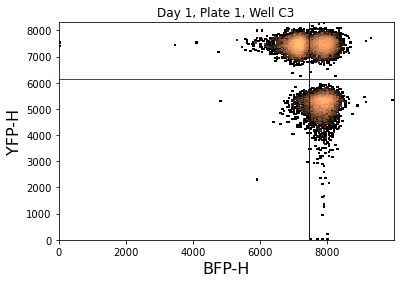

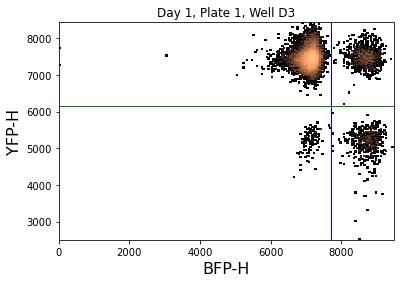

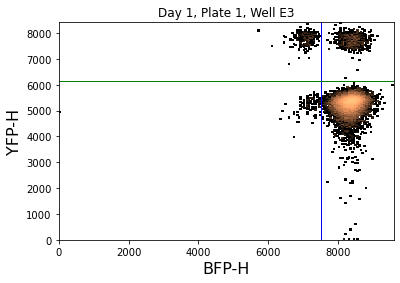

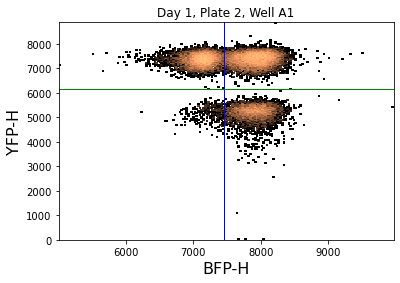

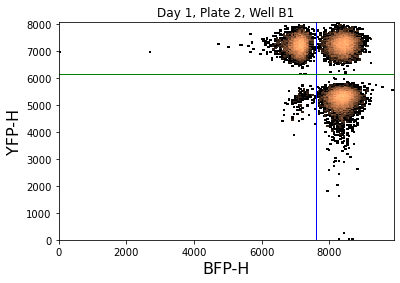

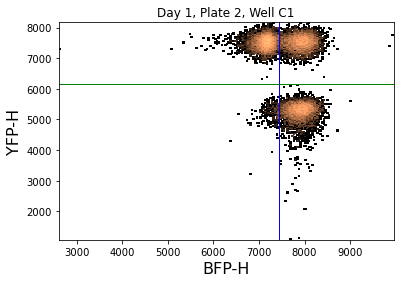

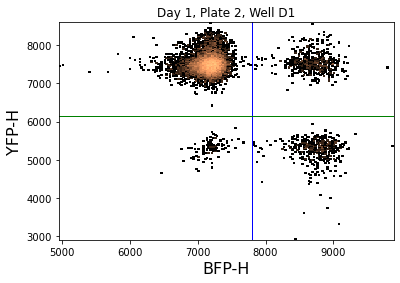

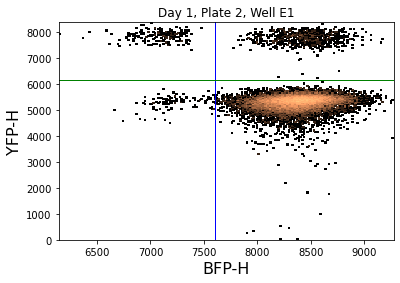

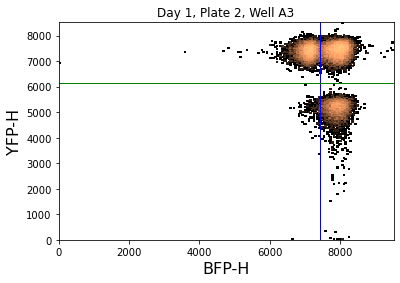

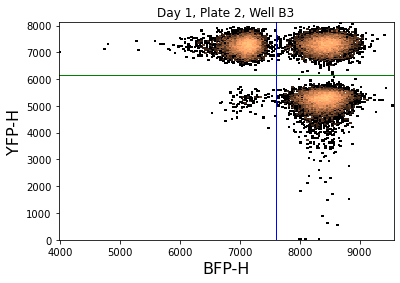

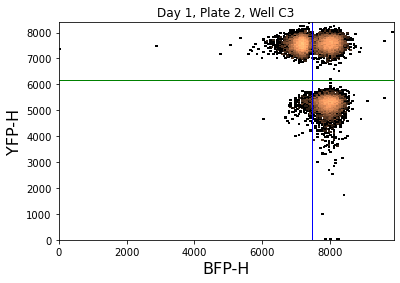

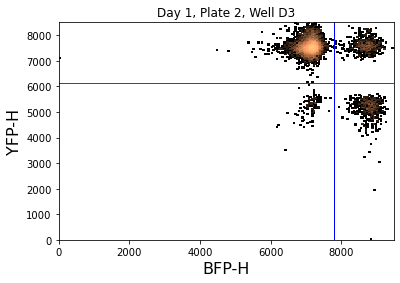

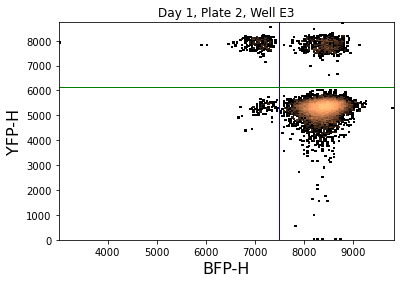

In [83]:
wells = ['A1','B1','C1','D1','E1','A3','B3','C3','D3','E3']

for day in days:
    for plate in plates[day]:
        for well in wells:
            #well = row + str(col)
            plt.figure()
            plot_plates(day, plates[day].index(plate), well, bfp_threshold, yfp_threshold)
            plt.title('Day %d, Plate %d, Well %s' % (day, plates[day].index(plate), well))
            plt.show()

In [84]:
b_data=[]

cols = [1,3]
rows = ['A','B','C','D','E']

for day in days:
    for row in rows:
        for col in cols:
            for plate in plates[day]:
                well = row + str(col)
                well_sort = str(col) + row
                try:
                    res,Q,bfp,yfp = get_bfp_freq(plate[well].data, day, plates[day].index(plate), well)
                except:
                    continue
                if day == 0 and col == 1:
                    group = "A-G1-3"
                if day == 0 and col == 3:  
                    group = "A-E4-6"
                if day == 1 and plates[day].index(plate)+1 == 1:
                    if row == 'A':
                        group = "A-G1-3_A"
                    if row == 'B':
                        group = "A-G1-3_B"
                    if row == 'C':
                        group = "A-G1-3_C"
                    if row == 'D':
                        group = "A-G1-3_D"
                    if row == 'E':
                        group = "A-G1-3_E"
                if day == 1 and plates[day].index(plate)+1 == 2:
                    if col == 1:
                        if row == 'A':
                            group = "A-G1-3_A"
                        if row == 'B':
                            group = "A-G1-3_B"
                        if row == 'C':
                            group = "A-G1-3_C"
                        if row == 'D':
                            group = "A-G1-3_D"
                        if row == 'E':
                            group = "A-G1-3_E"
                    if col == 3:
                        if row == 'A':
                            group = "A-E4-6_A"
                        if row == 'B':
                            group = "A-E4-6_B"
                        if row == 'C':
                            group = "A-E4-6_C"
                        if row == 'D':
                            group = "A-E4-6_D"
                        if row == 'E':
                            group = "A-E4-6_E"
                if day == 1 and plates[day].index(plate)+1 == 3:
                    if row == 'A':
                        group = "A-E4-6_A"
                    if row == 'B':
                        group = "A-E4-6_B"
                    if row == 'C':
                        group = "A-E4-6_C"
                    if row == 'D':
                        group = "A-E4-6_D"
                    if row == 'E':
                        group = "A-E4-6_E"
                    
                b_data.append({
                    'day':day,
                    'plate':plates[day].index(plate)+1,
                    'well':well,
                    'sort by well': well_sort,
                    'group': group,
                    'S freq': res[0],
                    'lambda': res[1],
                    'total count':Q,
                    'corrected total count': Q*res[1]/(1-np.exp(-res[1])),
                    'BFP':bfp,
                    'YFP':yfp,
                })     
            
df = pd.DataFrame(b_data)
df['f_trafo'] = np.arcsin(2*df['S freq'] - 1) #perform variance stabilizing transform
df.sort_values(['day','plate','sort by well'])

,day,plate,well,sort by well,group,S freq,lambda,total count,corrected total count,BFP,YFP,f_trafo
0,0,1,A1,1A,A-G1-3,0.503408,1.608840,27560,55432.822095,7932.292480,7394.950195,0.006815
2,0,1,B1,1B,A-G1-3,0.522032,1.215995,24357,42095.817541,8305.466797,7220.174316,0.044078
4,0,1,C1,1C,A-G1-3,0.474910,1.157313,23267,39271.350150,7920.224609,7568.151367,-0.050201
6,0,1,D1,1D,A-G1-3,0.685507,0.875676,18853,28297.159687,8328.185547,7543.209473,0.380102
8,0,1,E1,1E,A-G1-3,0.540542,1.535194,18688,36566.669491,8294.299805,7555.507812,0.081172
1,0,1,A3,3A,A-E4-6,0.454519,1.631523,28073,56941.233894,7893.655273,7391.569824,-0.091088
3,0,1,B3,3B,A-E4-6,0.521518,1.380176,20499,37800.303670,8287.263672,7029.733887,0.043049
5,0,1,C3,3C,A-E4-6,0.505646,1.256911,24382,42833.486024,7957.366211,7571.678711,0.011292
7,0,1,D3,3D,A-E4-6,0.076558,0.778706,14966,21541.783406,8757.857422,7552.244629,-1.010098
9,0,1,E3,3E,A-E4-6,0.968928,1.420628,23167,43394.054158,8357.493164,7871.955566,1.216402


In [85]:
df_var = df[df['day']==1].groupby(['group']).var().reset_index() #calculate variance
title_dict = {"A-G1-3_A":"REL 606 BFP:REL 606 YFP 50:50, daily mix", 
              "A-G1-3_B":"S BFP:S YFP 50:50, daily mix",
              "A-G1-3_C":"Sl1 BFP:Sl1YFP 50:50, daily mix", 
              "A-G1-3_D":"S BFP:L YFP 50:50, daily mix",
              "A-G1-3_E":"S BFP:Sl1 YFP 50:50, daily mix",
              "A-E4-6_A":"REL 606 BFP:REL 606 YFP 50:50, premixed",
              "A-E4-6_B":"S BFP:S YFP 50:50, premixed",
              "A-E4-6_C":"Sl1 BFP:Sl1YFP 50:50, premixed",
              "A-E4-6_D":"S BFP:L YFP 5:95, premixed",
              "A-E4-6_E":"S BFP:Sl1 YFP 95:5, premixed"}

df_var['group'] = df_var['group'].replace(title_dict)
df_var.head(50)

,group,day,plate,S freq,lambda,total count,corrected total count,BFP,YFP,f_trafo
0,"REL 606 BFP:REL 606 YFP 50:50, premixed",0.0,0.333333,0.000035,0.036042,1.003662e+07,1.203747e+08,997.191780,3693.674934,0.000144
1,"S BFP:S YFP 50:50, premixed",0.0,0.333333,0.000073,0.002819,2.291630e+06,1.336145e+07,1251.171284,1510.432790,0.000293
2,"Sl1 BFP:Sl1YFP 50:50, premixed",0.0,0.333333,0.000045,0.010099,8.238012e+06,1.178333e+07,1815.803273,2821.550173,0.000181
3,"S BFP:L YFP 5:95, premixed",0.0,0.333333,0.000035,0.024767,1.421514e+07,5.091891e+07,841.278240,2113.073960,0.000544
4,"S BFP:Sl1 YFP 95:5, premixed",0.0,0.333333,0.000010,0.015397,2.091346e+06,6.979431e+06,353.698088,2404.714656,0.000381
5,"REL 606 BFP:REL 606 YFP 50:50, daily mix",0.0,0.333333,0.001321,0.004236,9.744603e+05,9.024677e+06,824.085150,1057.057578,0.005294
6,"S BFP:S YFP 50:50, daily mix",0.0,0.333333,0.000560,0.006710,1.365849e+06,1.200531e+07,414.297105,724.685561,0.002286
7,"Sl1 BFP:Sl1YFP 50:50, daily mix",0.0,0.333333,0.000672,0.001142,1.789480e+06,4.043454e+06,117.264340,4207.277301,0.002708
8,"S BFP:L YFP 50:50, daily mix",0.0,0.333333,0.000432,0.004608,1.365076e+07,4.354424e+07,175.365933,293.026293,0.001835
9,"S BFP:Sl1 YFP 50:50, daily mix",0.0,0.333333,0.001685,0.046406,2.377763e+05,2.003977e+07,65.038451,3042.139154,0.006937


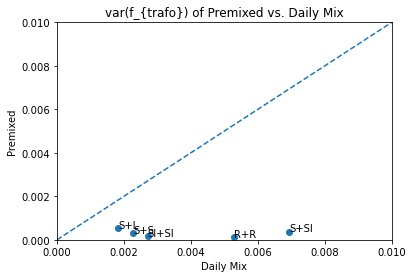

In [86]:
labels = ["R+R", "S+S", "Sl+Sl", "S+L", "S+Sl"]  

daily_var = df_var['f_trafo'][5:10]
premix_var = df_var['f_trafo'][0:5]
plt.scatter(daily_var, premix_var)

plt.title("var(f_{trafo}) of Premixed vs. Daily Mix")
plt.xlabel("Daily Mix")
plt.ylabel("Premixed")
plt.xlim(0, 0.01)
plt.ylim(0, 0.01)
for daily, pre, label in zip(daily_var, premix_var, labels):
    plt.text(daily, pre, label)
plt.plot([0,0.01],[0,0.01],'--')
plt.show()